In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
pip install --quiet datasets transformers rouge_score rapidfuzz matplotlib accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 41.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━

In [4]:
# Cell 1: installs + imports
import sys
import os

# If running in an environment where packages might be missing, uncomment the pip installs:
# !{sys.executable} -m pip install --quiet datasets transformers rouge_score rapidfuzz matplotlib accelerate

# Standard imports
import re
import random
import textwrap
import ast
from typing import List, Dict, Tuple

# Data / model libs
import datasets
from datasets import load_dataset

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Metrics & utilities
from rouge_score import rouge_scorer
from rapidfuzz.distance import Levenshtein

# Analysis / plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Print versions for reproducibility
print("torch:", torch.__version__)
import transformers
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)

torch: 2.6.0+cu124
transformers: 4.53.3
datasets: 4.4.1


In [5]:
# Cell 2: seeds and device
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
try:
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
except Exception:
    pass

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [8]:
# Cell 3: load dataset and preview
print("Loading dataset 'openai/openai_humaneval' (test split)...")
dataset = load_dataset("openai/openai_humaneval", split="test")

print("Dataset columns:", dataset.column_names)
n_examples = 20
examples = dataset.select(range(n_examples))

# Preview keys and a truncated prompt for example 0
print("\nExample 0 keys and truncated prompt preview:")
for k, v in examples[0].items():
    if isinstance(v, str):
        preview = v[:200].replace("\n", "\\n")
        print(f" - {k}: {preview}...")
    else:
        print(f" - {k}: {type(v)}")

# Ensure required fields exist
if "prompt" not in dataset.column_names or "canonical_solution" not in dataset.column_names:
    raise RuntimeError("Expected dataset fields 'prompt' and 'canonical_solution' not found.")
else:
    print(f"\nLoaded first {n_examples} examples. Ready to obfuscate + generate.")


Loading dataset 'openai/openai_humaneval' (test split)...


README.md: 0.00B [00:00, ?B/s]

openai_humaneval/test-00000-of-00001.par(…):   0%|          | 0.00/83.9k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/164 [00:00<?, ? examples/s]

Dataset columns: ['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point']

Example 0 keys and truncated prompt preview:
 - task_id: HumanEval/0...
 - prompt: from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given thr...
 - canonical_solution:     for idx, elem in enumerate(numbers):\n        for idx2, elem2 in enumerate(numbers):\n            if idx != idx2:\n                distance = abs(elem - elem2)\n                if distance < threshold...
 - test: \n\nMETADATA = {\n    'author': 'jt',\n    'dataset': 'test'\n}\n\n\ndef check(candidate):\n    assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.3) == True\n    assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2]...
 - entry_point: has_close_elements...

Loaded first 20 examples. Ready to obfuscate + generate.


In [9]:
# Cell 4: obfuscation functions

# Low-level helper using ast when possible; fallback to regex-based replacements.
def _regex_rename_simple(code: str) -> str:
    ids = re.findall(r"\b([a-zA-Z_][a-zA-Z0-9_]*)\b", code)
    ids = [i for i in ids if not i.isdigit()]
    ids = list(dict.fromkeys(ids))
    reserved = set([
        'def','return','if','else','for','while','in','and','or','not','import','from','as','with',
        'try','except','class','pass','break','continue','yield','lambda','True','False','None'
    ])
    mapping = {}
    idx = 1
    for identifier in ids:
        if identifier in reserved:
            continue
        if identifier.startswith('v') and identifier[1:].isdigit():
            continue
        mapping[identifier] = f'v{idx}'
        idx += 1
    out = code
    for a, b in mapping.items():
        out = re.sub(rf"\b{re.escape(a)}\b", b, out)
    return out

def low_obfuscation(code: str) -> str:
    """
    Light obfuscation: rename many identifiers to short names (v1, v2, ...), keep comments/docstrings.
    Attempts to parse with ast and preserve function name, fallbacks to regex renaming.
    """
    try:
        tree = ast.parse(code)
    except SyntaxError:
        return _regex_rename_simple(code)

    # collect names
    names = []
    class Collector(ast.NodeVisitor):
        def visit_Name(self, node):
            names.append(node.id)
            self.generic_visit(node)
    Collector().visit(tree)
    names = [n for n in dict.fromkeys(names) if not n.isdigit()]

    # exclude function name and common stuff
    func_name = None
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            func_name = node.name
            break

    mapping = {}
    short_names = [f"v{i}" for i in range(1, 1 + len(names))]
    si = 0
    import keyword
    for n in names:
        if n == func_name or keyword.iskeyword(n) or n == 'self':
            continue
        mapping[n] = short_names[si]
        si += 1
        if si >= len(short_names):
            break

    obf_code = code
    for old, new in mapping.items():
        obf_code = re.sub(rf"\b{re.escape(old)}\b", new, obf_code)
    return obf_code

def high_obfuscation(code: str) -> str:
    """
    High obfuscation: remove comments/docstrings, replace identifiers with generic varN,
    strip excessive whitespace.
    """
    # Remove single-line comments (naive)
    lines = code.splitlines()
    no_comments = []
    for ln in lines:
        if '#' in ln:
            # naive: drop after '#' (not handling # inside strings)
            ln = ln.split('#')[0]
        no_comments.append(ln)
    src = "\n".join(no_comments)

    try:
        tree = ast.parse(src)
    except SyntaxError:
        src = re.sub(r"\s+#.*", "", code)
        tree = ast.parse(src)

    names = set()
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            names.add(node.name)
            for arg in node.args.args:
                names.add(arg.arg)
        elif isinstance(node, ast.Name):
            names.add(node.id)
        elif isinstance(node, ast.arg):
            names.add(node.arg)
    import keyword, builtins
    names = [n for n in names if not keyword.iskeyword(n) and n not in dir(builtins) and len(n) > 0]

    mapping = {n: f"var{idx}" for idx, n in enumerate(names)}
    obf = src
    for old, new in mapping.items():
        obf = re.sub(rf"\b{re.escape(old)}\b", new, obf)
    # remove empty lines & trim
    obf = "\n".join([l.rstrip() for l in obf.splitlines() if l.strip() != ""])
    return obf


In [10]:
# Cell 5: test obfuscators
sample_prompt = examples[0]['prompt']
print("=== ORIGINAL (truncated) ===")
print(sample_prompt[:400].replace("\n", "\\n"))
print("\n=== LOW obfuscation (truncated) ===")
print(low_obfuscation(sample_prompt)[:400].replace("\n", "\\n"))
print("\n=== HIGH obfuscation (truncated) ===")
print(high_obfuscation(sample_prompt)[:400].replace("\n", "\\n"))


=== ORIGINAL (truncated) ===
from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n

=== LOW obfuscation (truncated) ===
from typing import v1\n\n\ndef has_close_elements(numbers: v1[v2], threshold: v2) -> v3:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n

=== HIGH obfuscation (truncated) ===
from typing import var1\ndef var0(var3: var1[float], var2: float) -> bool:\n    """ Check if in given list of var3, are any two var3 closer to each other than\n    given var2.\n    >>> var

In [11]:
# Cell 6: load tokenizer + model
model_name = "Salesforce/codet5-small"  # change if you'd like a different model
print("Loading model:", model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.to(device)
model.eval()
print("Model loaded. Device:", device)


Loading model: Salesforce/codet5-small


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

2025-12-03 08:59:26.029283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764752366.388167      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764752366.520426      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Model loaded. Device: cuda


In [12]:
# Cell 7: generation helper + quick test
def generate_completion(prompt_text: str, max_length: int = 256, num_beams: int = 1, do_sample: bool = False) -> str:
    inputs = tokenizer(prompt_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        out = model.generate(**inputs, max_length=max_length, num_beams=num_beams, do_sample=do_sample)
    decoded = tokenizer.decode(out[0], skip_special_tokens=True)
    return decoded

# Quick smoke-test with the original prompt of example 0
prompt0 = examples[0]['prompt']
print("Prompt (short):", prompt0[:200].replace("\n", "\\n"))
sample_completion = generate_completion(prompt0, max_length=256)
print("Sample completion (truncated):")
print(sample_completion[:500].replace("\n","\\n"))

Prompt (short): from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given thr
Sample completion (truncated):
has_close_elements(numbers: List[float], threshold:float):\n   0.5)\n   0.5)\n   0.5)\n   0.5)\n   0.5)\n   


In [13]:
# Cell 8: generate completions for original / low / high variants for first 20 examples
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

records = []
max_length = 256
for i, ex in enumerate(examples):
    orig_prompt = ex['prompt']
    canonical = ex['canonical_solution']
    low = low_obfuscation(orig_prompt)
    high = high_obfuscation(orig_prompt)
    variants = [("original", orig_prompt), ("low", low), ("high", high)]
    for varname, ptext in variants:
        print(f"Generating example {i} variant {varname} ...", end=" ")
        try:
            completion = generate_completion(ptext, max_length=max_length)
        except Exception as e:
            print("ERROR during generation:", e)
            completion = ""
        # Utility: ROUGE-L F1
        try:
            score = scorer.score(canonical, completion)
            rouge_l_f1 = score['rougeL'].fmeasure
        except Exception:
            rouge_l_f1 = 0.0
        # Privacy: normalized Levenshtein distance between prompt variants and original prompt
        try:
            raw = Levenshtein.distance(ptext, orig_prompt)
            maxlen = max(len(ptext), len(orig_prompt))
            privacy = raw / maxlen if maxlen > 0 else 0.0
        except Exception:
            privacy = 0.0

        records.append({
            "example_idx": i,
            "variant": varname,
            "prompt": ptext,
            "completion": completion,
            "canonical_solution": canonical,
            "utility": float(rouge_l_f1),
            "privacy": float(privacy)
        })
        print("done. utility={:.4f} privacy={:.4f}".format(rouge_l_f1, privacy))

df = pd.DataFrame(records)
print("\nGenerated total rows:", len(df))
print(df[["example_idx", "variant", "utility", "privacy"]].head(10))


Generating example 0 variant original ... done. utility=0.0909 privacy=0.0000
Generating example 0 variant low ... done. utility=0.0435 privacy=0.0632
Generating example 0 variant high ... done. utility=0.0000 privacy=0.2759
Generating example 1 variant original ... done. utility=0.0000 privacy=0.0000
Generating example 1 variant low ... done. utility=0.0889 privacy=0.0277
Generating example 1 variant high ... done. utility=0.0000 privacy=0.1166
Generating example 2 variant original ... done. utility=0.2857 privacy=0.0000
Generating example 2 variant low ... done. utility=0.0889 privacy=0.0302
Generating example 2 variant high ... done. utility=0.0000 privacy=0.1692
Generating example 3 variant original ... done. utility=0.0800 privacy=0.0000
Generating example 3 variant low ... done. utility=0.1111 privacy=0.0335
Generating example 3 variant high ... done. utility=0.0000 privacy=0.1250
Generating example 4 variant original ... done. utility=0.0000 privacy=0.0000
Generating example 4 v

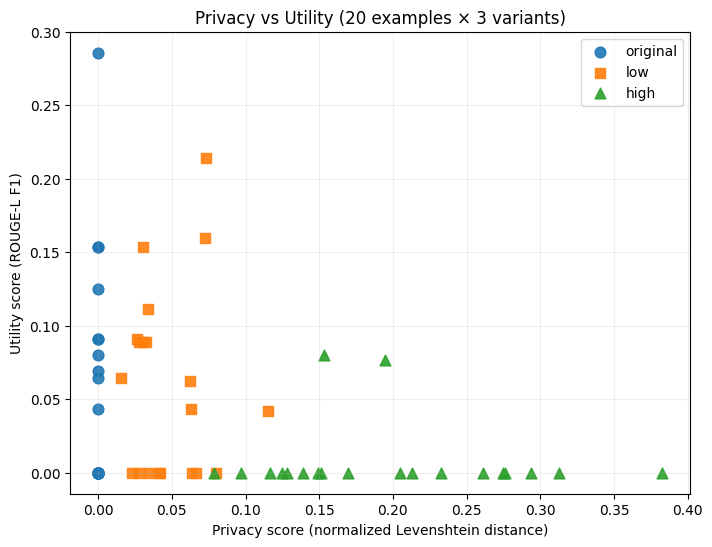


Summary by variant:
          utility                      privacy                        
            mean     std  min     max    mean     std     min     max
variant                                                              
high      0.0078  0.0242  0.0  0.0800  0.1977  0.0815  0.0788  0.3825
low       0.0604  0.0641  0.0  0.2143  0.0481  0.0253  0.0157  0.1155
original  0.0579  0.0766  0.0  0.2857  0.0000  0.0000  0.0000  0.0000


In [14]:
# Cell 9: plot and summary
plt.figure(figsize=(8,6))
markers = {'original':'o','low':'s','high':'^'}
for v in ['original','low','high']:
    sub = df[df['variant'] == v]
    plt.scatter(sub['privacy'], sub['utility'], label=v, marker=markers[v], s=60, alpha=0.9)

plt.xlabel('Privacy score (normalized Levenshtein distance)')
plt.ylabel('Utility score (ROUGE-L F1)')
plt.title('Privacy vs Utility (20 examples × 3 variants)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# Summary statistics
summary = df.groupby('variant')[['utility','privacy']].agg(['mean','std','min','max']).round(4)
print("\nSummary by variant:\n", summary)
